1. Initialization

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plot3dnasa as p3d #this is a python model that read/write in Plot3D format.

We read the grid file (.xyz).<br>
In this example, the grid is composed of 5 blocks, one at the center and four surrounding meshes.<br>
For surrounding meshes, the index direction is [radial, azimuthal, axial].

In [2]:
prefix = 'MultiblockJet'
g = p3d.Grid('%s.xyz'%prefix)
print 'center grid shape: ',g.get_size(0)
print 'surrounding grid shape: ',g.get_size(1)

center grid shape:  [ 33  33 512]
surrounding grid shape:  [256  33 512]


We extract Ffowc-Williams-Hawkings surface from the grid file.<br>
In this example, the surface is simply a cylidrical surface of constant radius $r=1.5D$.

In [3]:
def extract_const_r(g, f, r=0.5):
    n = f.get_size()
    g.set_subzone(1, [0, 0, 0], [-1, -1, 0]).load()
    idx = np.argmin(np.abs(np.mean(np.sqrt(g.xyz[0][:,:,0,0] ** 2 + 
                                           g.xyz[0][:,:,0,1] ** 2), 
                                   axis=1) - r)) 
    print 'radial index: ',idx
    args = dict()
    if type(f) == p3d.Function:
        args.update(ncomponents=f.ncomponents)
    fe = type(f)(**args).set_size([n[0][2], 4 * (n[1][1] - 1) + 1, 1], True)
    for i in range(1, 5): 
        f.set_subzone(i, [idx, 0, 0], [idx, -2, -1]).load()
        for j in range(f[0].shape[-1]):
            fe[0][:,(i-1)*(n[1][1]-1):i*(n[1][1]-1),0,j] = f[0][0,:,:,j].T
        fe[0][:,-1,:,:] = fe[0][:,0,:,:]
    return fe, idx

R0 = 1.5
ge, radial_idx = extract_const_r(g, g, r=R0)
n = ge.get_size(0)
print 'r=%f surface grid shape: (%d,%d,%d)' % (R0,n[0],n[1],n[2])

radial index:  154
r=1.500000 surface grid shape: (512,129,1)


Mean pressure on FWH surface is required. <br>
For the sake of demonstration, it is simply chosen to be $1/\gamma$ (non-dimensionalized).

In [4]:
gamma = 1.4
meanP = 1/gamma

Create array of 2 mikes at distance $d=94D$ from a jet nozzle $(-1.2,0,0)$,<br>
with an angle of $\theta=30^{o}$ from the axis.

In [5]:
from mike import *

def get_mikes(n, x0, d, theta):                                                       
    """Returns a list of mikes distributed uniformly on a ring parallel               
    to the x-y plane whose center is at a distance `d` * cos(`theta`)                 
    from `x0`. The first mike is located on the x-z plane, and the mikes              
    are ordered in counter-clockwise direction when viewed from                       
    z=-inf."""                                                                        
    phi = np.linspace(0., 2. * np.pi, n + 1)[:-1]                                     
    return [Mike([x0[0] + d * np.sin(np.pi * theta / 180.) * np.cos(phi[i]),          
                x0[1] + d * np.sin(np.pi * theta / 180.) * np.sin(phi[i]),          
                x0[2] + d * np.cos(np.pi * theta / 180.)]) for i in range(n)] 

x0 = [-1.2,0.,0.]
d, theta = 1e6, 90.
mikes = get_mikes(2,x0,d,theta)

Specify solution data at FWH surface.<br>
Data is written in binary .dat files. (You will have to write your own routine for this)<br>
Data is composed of 5 state variables, $(\rho, \rho u, \rho v, \rho w, \rho E)$.<br>
In this example, there are 4 solution data files corresponding to north, south, west, east part of FWH surface.<br>
In following code, 'get_fromfile' function reads these 4 data files into one single solution array.<br>
This function is periodically used in integration of FWH equation.

In [6]:
probe_files = ['%s.probe_test.%s.dat' % (prefix,s) for s in ['E','N','W','S']]
nsamples = os.stat(probe_files[0]).st_size/(40 * n[0] * ((n[1] - 1) / 4 + 1))
print '1 sample probe data has %d bytes, %d variables, %d streamwise \
indexes, %d azimuthal indexes'%(8,5,n[0],(n[1]-1)/4+1)
print 'number of samples: ', nsamples
    
def get_fromfile(offset, size, n, probe_files):
    q = np.empty([n[1], n[0], 5, size], order='F')
    m = (n[1] - 1) / 4 + 1
    n = 8 * m * n[0] * 5 * size
    for i, filename in enumerate(probe_files):
        with open(filename) as f:
            f.seek(offset * n / size)
            data_buffer = np.fromstring(f.read(n),dtype='<f8')
            inserting_array = np.reshape(
                data_buffer, [m, q.shape[1], 5, size],
                order='F')[:-1,:,:,:]
            q[i*(m-1):(i+1)*(m-1),:,:,:] = inserting_array
    return q  #return [azimuthal,streamwise,5,size]-shaped array

1 sample probe data has 8 bytes, 5 variables, 512 streamwise indexes, 33 azimuthal indexes
number of samples:  151


Create FWHSolver object.<br>
In initiation of this object, two routines have to be written on your own.<br>
1. _compute_normals(FWHSolver, xyz) in fwhsolver.py<br>
compute normal vectors of all cells in FWHsurface grid.<br>
In this example, the grid is structured.<br>
2. set_params(mike,...) in mike.py<br>
compute distance, radiation direction (mike.disp) from each cell on FWHsurface to mike position. Also other parameters.

In [7]:
import fwhsolver as fwh
timestep_size = 1.2e-3
sampling_timesteps = 35
dt = sampling_timesteps * timestep_size
solver = fwh.FWHSolver(ge, mikes, nsamples, dt, probe_files=probe_files, meanP=meanP)

Implement the surface integral of FWH equation, at each mike position.
This 'integrate' routine is composed of mainly 3 parts:
1. reads the data and converts the state variable into $(\rho^{-1},\rho u, \rho v,\rho w, p-\bar{p})$
2. mike.add_contribution: compute monopole/dipole source from solution and the surface integral
3. mike.update_signal: convert the surface integral on FWH surface into time history of p' at mike position<br>
<br>
chunk_size is the size of buffer into which you read the data.

In [8]:
solver.integrate(chunk_size=10)

Processing FWH data...


100% [==========================================================] Time: 0:00:27


Save time history of pressure fluctuation at each mike.

In [9]:
p0 = np.zeros([mikes[0].p.shape[0],len(mikes)])
for i, mike in enumerate(mikes):
    p0[:,i] = mike.p
    with open('fwh_mike%02d.dat' % (i + 1), 'w') as f:
        np.savetxt(f, np.array([mike.t, mike.p]).T, fmt='%+.18E')

Compute scaled sound spectrum (SPL or OASPL) from the pressure fluctuation time history.<br>
Here the data samples are too few to collect enough statistics for turbulent sound spectrum.<br>
It is only for demonstration purpose.

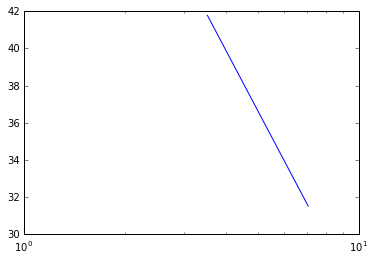

In [10]:
def windowed_fft(p, num_windows=5, dt=35*1.2e-3, mach_number=1.3, gamma=1.4):
    import numpy.fft
    n = p.shape[0]
    m = 2 * (n / (num_windows + 1))
    windows = [((int(0.5 * i * m), int(0.5 * i * m) + m))
               for i in range(num_windows)]
    temperature_ratio = 1. / (1. + 0.5 * (gamma - 1.) * mach_number ** 2)
    u_j = mach_number * np.sqrt(temperature_ratio)
    St = numpy.fft.fftfreq(m, d=dt)[1:m/2] / u_j
    y = np.empty([m / 2, num_windows, p.shape[1]])
    window_func = np.blackman(m)
    for j in range(p.shape[1]):
        for i, w in enumerate(windows):
            y[:,i,j] = np.absolute(numpy.fft.fft(
                p[w[0]:w[1],j] * window_func))[:m/2] / (m * window_func.mean())
            y[1:,i,j] *= np.sqrt(2.)
    p_ref = 20.e-6 / 101325. / gamma
    OASPL = 10. * np.log10(np.mean(np.sum(np.mean(
        y[1:] ** 2, axis=1), axis=0)) / p_ref ** 2)
    SPL = 10. * np.log10(np.mean(np.mean(y[1:] ** 2, axis=1), axis=1) /
                         p_ref ** 2)
    SPL += 10. * np.log10(1. / dt / n)
    return St, SPL, OASPL

St, SPL, OASPL = windowed_fft(p0, dt=dt)
data = np.zeros([SPL.size,3])
data[:,0] = St
data[:,1] = SPL
data[:,2] = OASPL
np.savetxt('SPL_test.dat', data, fmt ='%+.18E')
plt.semilogx(St,SPL)